<a href="https://colab.research.google.com/github/harim061/CNN/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4차원 배열

In [ ]:
import numpy as np

In [ ]:
# CNN에 흐르는 4차원 형태 (데이터수, 채널수, h, w)
x = np.random.rand(10,1,28,28)
x.shape

(10, 1, 28, 28)

In [ ]:
# 10개 중 첫 번째 데이터에 접근

print(x[0].shape)

# 10개 중 두 번째 데이터에 접근
x[1].shape

(1, 28, 28)


(1, 28, 28)

In [ ]:
# 첫 채널의 첫 번째 데이터
x[0,0]

array([[0.10903896, 0.1419979 , 0.68176155, 0.84989664, 0.03759913,
        0.41212248, 0.12755239, 0.23619769, 0.88523736, 0.08495315,
        0.6829678 , 0.86298407, 0.13029742, 0.73153819, 0.86112611,
        0.68079555, 0.51144907, 0.78148802, 0.1970309 , 0.30868665,
        0.95168939, 0.55432951, 0.22783353, 0.19054211, 0.20967677,
        0.44105433, 0.82515972, 0.79435463],
       [0.53067213, 0.63570277, 0.40155468, 0.84703829, 0.94177962,
        0.5222432 , 0.04992131, 0.08087957, 0.28460171, 0.95390537,
        0.53446648, 0.17281191, 0.92850948, 0.2253689 , 0.31908687,
        0.55847119, 0.86692047, 0.30685401, 0.29263427, 0.14539161,
        0.32040372, 0.19076879, 0.25639377, 0.77099265, 0.92428736,
        0.05655002, 0.56892824, 0.21222873],
       [0.13280175, 0.69821503, 0.87740672, 0.68130218, 0.098652  ,
        0.28957207, 0.65470312, 0.74028133, 0.94175292, 0.33331509,
        0.10902044, 0.2362916 , 0.70366226, 0.52205119, 0.92684362,
        0.76882689, 0.4775

# im2col로 데이터 전개하기

- 합성곱 연산을 구현하려면 for문 사용해야함 우웅. .귀차나 -> im2col 사용
- 3차원 입력 데이터 ->(im2col) -> 2차원 행렬로 변환
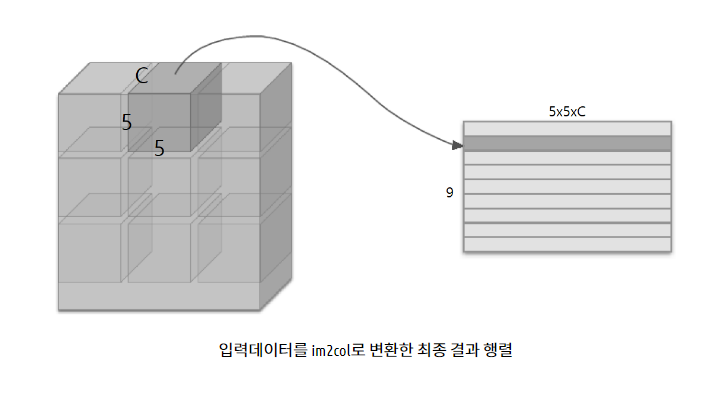

# 합성곱 계층 구현하기

## im2col(input_data, filter_h, filter_w, stride = 1, pad = 0)


In [ ]:
# im2col 함수 정의
def im2col(input_img, FH, FW, stride=1, pad=0):
    N, C, H, W = input_img.shape
    out_h = 1 + int((H + 2 * pad - FH) / stride)
    out_w = 1 + int((W + 2 * pad - FW) / stride)
    img = np.pad(input_img, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')  # pad 0
    out_img = np.zeros((N, C, FH, FW, out_h, out_w))
    for y in range(FH):
        y_max = y + out_h * stride
        for x in range(FW):
            x_max = x + out_w * stride
            out_img[:, :, y, x, :, :] = img[:, :, y:y_max:stride,x:x_max:stride]
    out_img = np.transpose(out_img,(0, 4, 5, 1, 2, 3))  # N,OH,OW,C,FH,FW
    out_img = out_img.reshape(N * out_h * out_w, -1)  # inmage 를 reshape height N*out_h*out_w，width C*FW*FH
    return out_img

In [ ]:
import sys, os
sys.path.append(os.pardir)


In [ ]:
x1 = np.random.rand(1,3,7,7)
col1 = im2col(x1,5,5,stride=1, pad=0)
print(col1.shape)

(9, 75)


In [ ]:
x2 = np.random.rand(10,3,7,7)
col2 = im2col(x2,5,5,stride=1,pad=0)
print(col2.shape)

(90, 75)


In [ ]:
class Convolution:
  def __init__(self,W,b,stride=1,pad=0):
    # 초기화
    self.W = W
    self.b = b
    self.stride = stride
    self.pad = pad

  def forward(self,x):
    # 필터
    FN,C,FH,FW = self.W.shape

    N,C,H,W = x.shape

    out_h = int(1+(H + 2*self.pad - FH)/self.stride)
    out_w = int(1+(W + 2*self.pad - FW)/self.stride)

    # 입력 데이터 im2col로 전개
    col  = im2col(x,FH,FW,self.stride, self.pad)

    # 필터 reshape 2차원 배열로 전개
    col_W = self.W.reshape(FN, -1).T

    # 두 행렬의 내적을 구함
    out = np.dot(col,col_W) + self.b

    # 인덱스를 지정하여 배열의 축 순서를 바꿔줌
    out = out.reshape(N , out_h, out_w, -1).transpose(0,3,1,2)

    return out



**reshape에 -1 지정** -> 다차원 배열의 원소 수가 변환 후에도 똑같이 유지되돋록 묶어줌

(10,3,5,5) -> 750개

reshape(10,-1) -> 750개의 원소를 10묶음으로 (10,75)인 배열로 만들어줌

# 풀링 계층 구현하기
- 채널 쪽이 독립적이라는 점

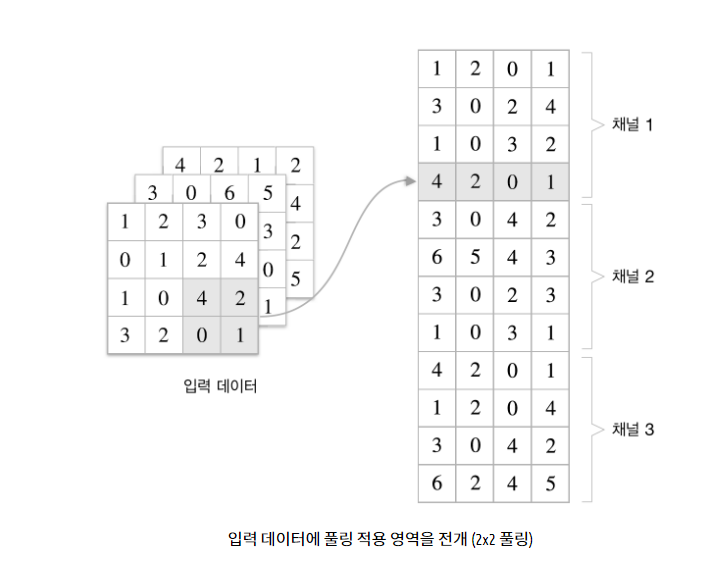

- 행렬에서 행별 최댓값을 구하고 적절한 형상을 성형

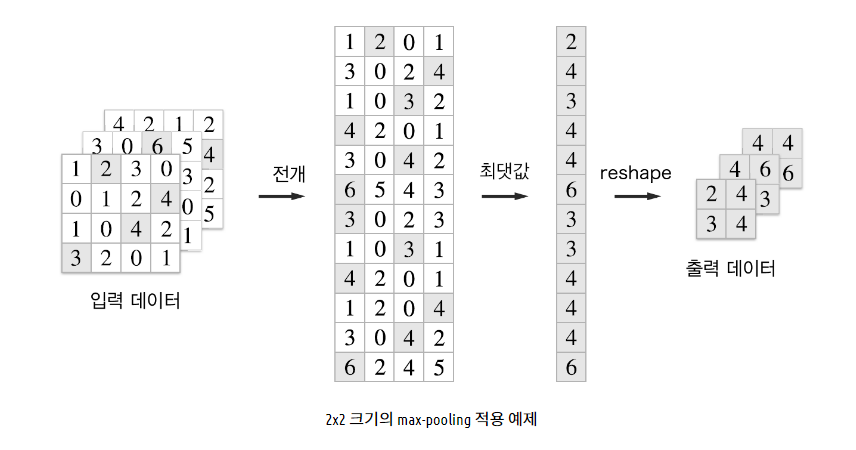

1. 입력 데이터를 전개
2. 행별 최댓값을 구함
3. 적절한 모양으로 성형

In [ ]:
class Pooling:
  def __init__(self, pool_h, pool_w, stride=1, pad=0):
    self.pool_h = pool_h
    self.pool_w = pool_w
    self.stride = stride
    self.pad = pad

  def forward(self,w):
    N,C,H,W = x.shape
    out_h = int( 1 + (H - self.pool_h )/self.stride)
    out_w = int( 1 + (W - self.pool_w )/self.stride)

    # 전개(1)
    col = im2col(x,self.pool_h, self.pool_w, self.stride,self.pad)
    col = col.reshape(-1, self.pool_h * self.pool_w)

    # 최댓값(2)
    out = np.max(col,axis=1)

    # 성형(3)
    out = out.reshape(N,out_h,out_w,C).transpose(0,3,1,2)

    return out

# CNN 구현하기
- 합성곱 계층의 하이퍼파라미터는 딕셔너리 형태
- hidden_size = 은닉층의 뉴런 수
- output_size = 출력층의 뉴런 수
- weight_init_sed = 초기화 때 가중치 표준편차

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b

        self.x = None
        self.original_x_shape = None

        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)
        return dx

In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx


In [ ]:
from collections import OrderedDict

In [ ]:
class SimpleConvNet:
  def __init__(self,input_dim= (1,28,28),
               conv_param = {'filter_num':30, "filter_size":5,'pad':0,'stride':1},
               hidden_size=100, output_size=10,weight_init_std = 0.01):
    filter_num = conv_param['filter_num'] # 30
    filter_size = conv_param['filter_size'] # 5
    filter_pad = conv_param['pad'] # 0
    filter_stride = conv_param['stride'] # 1
    input_size = input_dim[1] # 28

    # 계산
    conv_output_size =  (input_size - filter_size + 2*filter_pad/filter_stride + 1) # 24
    pool_output_size = int(filter_num * (conv_output_size/2) * conv_output_size/2) # 4320

    # 매개변수 생성
    self.params = {}

    self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0],filter_size,filter_size)  # 1번째 층의 합성공 계층의 가중치  0.01 * 30 * 1 * 5 * 5
    self.params['b1'] = np.zeros(filter_num) # 편향 30
    self.params['W2'] = weight_init_std * np.random.rand(pool_output_size, hidden_size) # 0.01 * 4320 * 100
    self.params['b2'] = np.zeros(hidden_size) # 100
    self.params['W3'] = weight_init_std * np.random.randn(hidden_size,output_size) # 0.01 * 100 * 10
    self.params['b3'] = np.zeros(output_size) # 10) # 4320


    # 계층 구성
    # 순서가 있는 OrderDict에 계층 차례대로 추가

    self.layers = OrderedDict()
    self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                        conv_param['stride'],conv_param['pad'])
    self.layers['Relu1'] = Relu()
    self.layers['Pool1'] = Pooling(pool_h=2,pool_w=2,stride=2)
    self.layers['Affine1'] = Affine(self.params['W2'],self.params['b2'])
    self.layers['Relu2'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W3'],self.params['b3'])
    self.last_layer = SoftmaxWithLoss()



    # 계층 맨 앞에서부터 forward 메서드를 호출해서 겨로가를 다음 계층에 전달
    def predict(self,x):
      for layer in self.layers.values():
        x = layer.forward(x)
      return x

    def loss(self,x,t):
      y = self.predict(x)
      return self.lastLayer.forward(y,t)

    def gradient(self,x,t):
      # 순전파
      self.loss(x,t)

      # 역전파
      dout = 1
      dout = self.last_layer.backward(dout)

      layers = list(self.layers.values())
      layers.reverse()
      for layer in layers:
          dout = layer.backward(dout)

      grads = {}
      grads['W1'] = self.layers['Conv1'].dW
      grads['b1'] = self.layers['Conv1'].db
      grads['W2'] = self.layers['Affine1'].dW
      grads['b2'] = self.layers['Affine1'].db
      grads['W3'] = self.layers['Affine2'].dW
      grads['b3'] = self.layers['Affine2'].db

      return grads